<a href="https://colab.research.google.com/github/srini229/EE5333_tutorials/blob/master/fp/Floorplanning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulated Annealing

<img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/fp/fig/sim_anneal.jpg" width=507 height=569 />

  + Accept$(C, T) = e^{\frac{-\Delta C}{k T}}$

In [ ]:
import math
import random

def accept(delC, T):
  if delC <= 0: return True
  return random.random() < math.exp(-delC/T)

# F = initial slicing floorplan in Polish form
# costEval(F): cost evaluation routine
# accept(\Delta C, T): accept routine
# perturb(F): perturbation routine
def sa(Tmin, Tmax, N, alpha, F, costEval, accept, perturb, plot = True):
  assert(alpha < 1. and Tmin < Tmax)
  T = Tmax
  C = costEval(F)
  minC = C
  minF = F[:]
  Clist = []
  Temp = []
  while T > Tmin:
    for i in range(N):
      Fnew = perturb(F)
      Cnew = costEval(Fnew)
      if accept(Cnew - C, T):
        C, F = Cnew, Fnew
        if minC >= Cnew:
          minC, minF = Cnew, Fnew
        Clist.append(Cnew)
        Temp.append(T)
    T = T * alpha
  if plot:
    import matplotlib.pyplot as plt
    plt.plot(Temp, Clist)
    plt.xlim(max(Temp), min(Temp))
    plt.xscale('log')
  return minF, minC

# Slicing floorplan routines

In [41]:
operators = {'H', 'V'} # operators corresponding to H and V slices

class Module:
  def __init__(self, name, area, aspect_ratios):
    self._name = name
    self._area = area
    self._xy = [(math.sqrt(area*r), math.sqrt(area/r)) for r in aspect_ratios]
  def __repr__(self):
    return f"'{self._name} area:{self._area} xy:{self._xy}'"

def checkBalloting(F, index):
  countOperators = 0
  for i in range(index+1):
    if F[i] in operators:
      countOperators += 1
  if 2 * countOperators >= index:
    return False
  return True

def perturb(Fi):
  F = Fi[:]
  choice = random.randint(1,3)
  last = len(F) - 1
  match choice:
    case 1:
      done = False
      while not done:
        index = random.randint(0, last)
        if F[index] in operators: continue
        if index < last and F[index+1] not in operators:
          F[index], F[index + 1] = F[index + 1], F[index]
          done = True
        elif index > 0 and F[index-1] not in operators:
          F[index], F[index - 1] = F[index - 1], F[index]
          done = True
    case 2:
      done = False
      while not done:
        index = random.randint(0, last)
        if F[index] not in operators: continue
        b = index - 1
        e = index + 1
        if random.random() < 0.5:
          while b >= 0 and F[b] in operators:
            b -= 1
        if random.random() < 0.5:
          while e <= last and F[e] in operators:
            e += 1
        for i in range(b+1, e):
          if F[i] == 'H': F[i] = 'V'
          elif F[i] == 'V': F[i] = 'H'
        done = True
    case _:
      done = False
      iter = 0
      while not done and iter < len(F):
        index = random.randint(0, last)
        next = index + 1 if index < last else index - 1
        if F[index] not in operators and F[next] in operators and checkBalloting(F, max(index, next)):
          F[index], F[next] = F[next], F[index]
          done = True
        elif F[index] in operators and F[next] not in operators and checkBalloting(F, max(index, next)):
            F[index], F[next] = F[next], F[index]
            done = True
        iter += 1
  return F


def _costEval(a, b, operator):
  xindexed = dict()
  yindexed = dict()
  for ai in a:
    for bi in b:
      e = (max(ai[0], bi[0]), ai[1] + bi[1]) if operator == 'H' else (ai[0] + bi[0], max(ai[1], bi[1]))
      if e[0] not in xindexed and e[1] not in yindexed:
        xindexed[e[0]] = e
        yindexed[e[1]] = e
      elif e[0] in xindexed:
        if xindexed[e[0]][1] > e[1]:
          xindexed[e[0]] = e
          yindexed[e[1]] = e
      elif e[1] in yindexed:
        if yindexed[e[1]][0] > e[0]:
          xindexed[e[0]] = e
          yindexed[e[1]] = e
  return [v for k, v in xindexed.items()]

def costEval(F):
  cost = [] # stack
  for f in F:
    if f in operators:
      assert(len(cost) >= 2)
      b = cost.pop()
      a = cost.pop()
      cost.append(_costEval(a, b, f))
    else:
      cost.append(f._xy)

  assert(len(cost) > 0)
  return min([i[0] * i[1] for i in cost[0]])

class Position:
  def __init__(self, name, origin = (0.,0.), operator = None, left = None, right = None, xy = None):
    self._name = name
    self._origin = origin
    self._operator = operator
    self._left = left
    self._right = right
    if None == xy and self._right and self._left:
      ax, ay = self._left._xy
      bx, by = self._right._xy
      self._xy = (max(ax, bx), ay + by) if self._operator == 'H' else (ax + bx, max(ay, by))
    else:
      self._xy = xy
  def __repr__(self):
    return f'\n[{self._name}  origin:{self._origin} op:{self._operator} dim:{self._xy}]'

def findCoord(F):
  evalOrder = [] # stack
  stackTracker = []
  for i in range(len(F)):
    f = F[i]
    if f in operators:
      a = evalOrder.pop()
      b = evalOrder.pop()
      stackTracker.append(b)
      stackTracker.append(a)
      evalOrder.append(Position(f+f'_{i}', (0,0), f, b, a))
    else:
      evalOrder.append(Position(f._name, (0,0), None, None, None, f._xy[0]))
  assert(len(evalOrder) == 1)
  stackTracker.append(evalOrder.pop())
  for i in range(len(stackTracker)-1, -1, -1):
    curr = stackTracker[i]
    if curr._operator in operators:
      curr._left._origin = (curr._origin[0], curr._origin[1])
      if curr._operator == 'H':
        curr._right._origin = (curr._origin[0], curr._origin[1] + curr._left._xy[1])
      elif curr._operator == 'V':
        curr._right._origin = (curr._origin[0] + curr._left._xy[0], curr._origin[1])

  coord = [(c._origin, c._xy, c._name) for c in stackTracker if c._operator not in operators]
  return coord

def slicing_floorplan(m):
  F = [m[0]]
  for i in range(1, len(m)):
    F.append(m[i])
    F.append('V')
  Tmax = sum([i._area for i in m])
  Fmin, Cmin = sa(1, Tmax, 100, 0.9, F, costEval, accept, perturb, False)
  coords=findCoord(Fmin)
  return (coords, Cmin)

## Plotting utils

In [42]:
def plot(coords):
  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle

  fig, ax = plt.subplots()
  ax.plot([0, 0])
  ax.set_aspect('equal')
  ax.set_xlim(0,max([r[0][0] + r[1][0] for r in coords]))
  ax.set_ylim(0,max([r[0][1] + r[1][1] for r in coords]))

  for i,r in enumerate(coords):
    match i%4:
      case 3: hatch, color = '/+', 'red'
      case 2: hatch, color = '///', 'green'
      case 1: hatch, color = '/\//\//\/', 'blue'
      case _: hatch, color = '\\\\\\', 'gray'
    ax.add_patch(Rectangle(r[0], r[1][0], r[1][1],
              edgecolor = color, facecolor=color,
              hatch=hatch, fill = False,
              lw=2))
    ax.text(r[0][0] + r[1][0]//2, r[0][1] + r[1][1]//2, r[2], fontsize=8)
  plt.show()

# ILP floorplanner

<img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/fp/fig/ilp_fp.jpg" width=585 height=413 />


In [43]:
!pip install mip

In [44]:
def ilp_floorplan(modules, aspect_ratio = None, margin = 0.01):
  import mip
  model = mip.Model("Floorplan")
  Mx = sum([max([xy[0] for xy in m._xy]) for m in modules])
  My = max(2*Mx, sum([max([xy[1] for xy in m._xy]) for m in modules]))
  x = [model.add_var(f"x_{m._name}", lb=0., ub=Mx) for m in modules]
  y = [model.add_var(f"y_{m._name}", lb=0., ub=Mx) for m in modules]
  w = [model.add_var(f"w_{m._name}", lb=min([xy[0] for xy in m._xy]), ub=max([xy[0] for xy in m._xy])) for m in modules]
  h = [model.add_var(f"h_{m._name}", lb=min([xy[1] for xy in m._xy]), ub=max([xy[1] for xy in m._xy])) for m in modules]
  t1 = dict()
  t2 = dict()
  for i in range(len(modules)):
    for j in range(i + 1, len(modules)):
      t1[(i,j)] = model.add_var(f"t1_{modules[i]._name}_{modules[j]._name}", var_type=mip.BINARY)
      t2[(i,j)] = model.add_var(f"t2_{modules[i]._name}_{modules[j]._name}", var_type=mip.BINARY)
  Mavg = (Mx + My)/2.
  W = model.add_var(f'W')
  H = model.add_var(f'H')
  z1 = model.add_var(f'z1', lb = 0, ub = Mavg)
  z2 = model.add_var(f'z2', lb = min(0, (Mx - My)), ub = Mx)

  model += z1 == (W + H) / 2
  model += z2 == (W - H) / 2

  z1sq = model.add_var(f'z2sq', lb=0, ub = (Mavg)**2)
  z2sq = model.add_var(f'z1sq', lb=0, ub = Mx**2)

  model += z1sq >= z2sq
  N = 25 # number of points in the piecewise linear approx. of z_1^2
  z1range = [model.add_var(f'z1_{i}', lb = 0., ub = 1.) for i in range(N)]
  z2range = [model.add_var(f'z2_{i}', lb = 0., ub = 1.) for i in range(N)]
  model += mip.xsum(z1range) == 1
  model += mip.xsum(z2range) == 1
  model.add_sos([(z1range[i], Mavg*i/N) for i in range(N)], 2)
  model.add_sos([(z2range[i], Mx*i/N) for i in range(N)], 2)

  model += z1 == mip.xsum([z1range[i]*(Mavg*i/N) for i in range(N)])
  model += z2 == mip.xsum([z2range[i]*(Mx*i/N) for i in range(N)])

  model += z1sq == mip.xsum([z1range[i]*((Mavg*i/N)**2) for i in range(N)])
  model += z2sq == mip.xsum([z2range[i]*((Mx*i/N)**2) for i in range(N)])

  model.verbose = 0
  model.objective = mip.minimize(z1sq - z2sq)

  if None != aspect_ratio:
    model += W >= (aspect_ratio - margin)* H
    model += W <= (aspect_ratio + margin)* H

  s = [[model.add_var(f"s_{m._name}_{j}", var_type=mip.BINARY) for j in range(len(m._xy))] if len(m._xy) > 1 else [] for m in modules]
  for i, si in enumerate(s):
    model += x[i] + w[i] <= W
    model += y[i] + h[i] <= H
    if len(si):
      model += mip.xsum(si) == 1
      model += mip.xsum([si[j]*modules[i]._xy[j][0] for j in range(len(modules[i]._xy))]) == w[i]
      model += mip.xsum([si[j]*modules[i]._xy[j][1] for j in range(len(modules[i]._xy))]) == h[i]
    elif len(modules[i]._xy) == 1:
      model += w[i] == modules[i]._xy[0][0]
      model += h[i] == modules[i]._xy[0][1]

  for i in range(len(modules)):
    for j in range(i + 1, len(modules)):
      model += x[i] + w[i] - x[j] <= Mx * t1[(i,j)] + My * t2[(i,j)]
      model += x[j] + w[j] - x[i] <= Mx - Mx * t1[(i,j)] + My * t2[(i,j)]
      model += y[i] + h[i] - y[j] <= Mx * t1[(i,j)] + My - My * t2[(i,j)]
      model += y[j] + h[j] - y[i] <= Mx - Mx * t1[(i,j)] + My - My * t2[(i,j)]
  model.write("floorplan.lp")
  model.optimize()

  if model.status == mip.OptimizationStatus.OPTIMAL:
    sol = [((x[i].x, y[i].x), (w[i].x, h[i].x), modules[i]._name) for i in range(len(modules))]
    return (sol, W.x * H.x)
  return None


# Sequence-pair floorplanner

In [45]:
# m is a list of modules; see definition of the module class above
def sp_floorplan(m):
  sol, area = None, None
  return (sol, area)

# Examples

ilp_floorplan runtime : 0.14230847358703613
ilp_floorplan area : 81.0 Utilization : 100.0


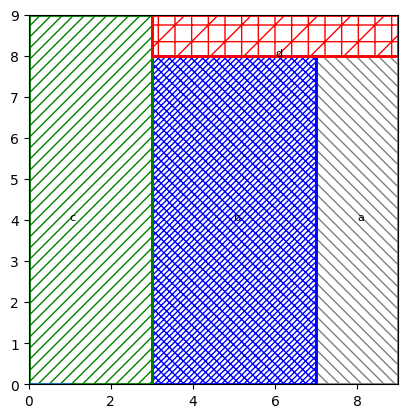

slicing_floorplan runtime : 0.06056404113769531
slicing_floorplan area : 81.0 Utilization : 100.0


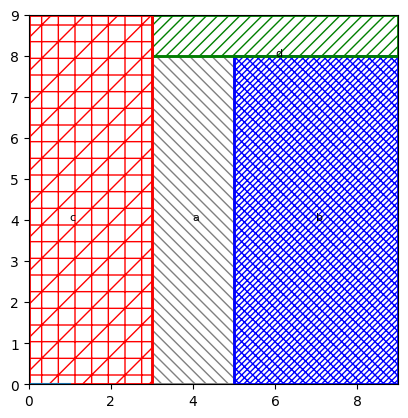

sp_floorplan runtime : 3.5762786865234375e-06


In [50]:
import time
m = [Module('a', 16, [0.25, 4]), Module('b', 32, [0.5, 2.0]), Module('c', 27, [1./3, 3.]), Module('d', 6, [6])]
sumarea = sum([i._area for i in m])
for fpfn in [ilp_floorplan, slicing_floorplan, sp_floorplan]:
  t = time.time()
  sol, area = fpfn(m)
  print(f"{fpfn.__name__} runtime :", time.time() - t)
  if sol:
    print(f"{fpfn.__name__} area :", area, "Utilization :", sumarea * 100./area)
    plot(sol)

ilp_floorplan runtime : 14.26889419555664
ilp_floorplan area : 267.90444584645684 Utilization : 90.70398187392148


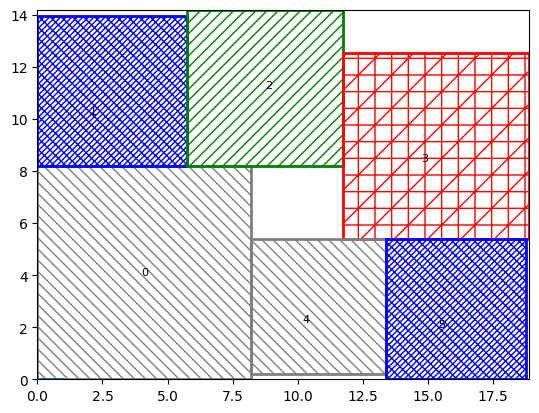

slicing_floorplan runtime : 0.13483572006225586
slicing_floorplan area : 281.96629714476796 Utilization : 86.18051251537989


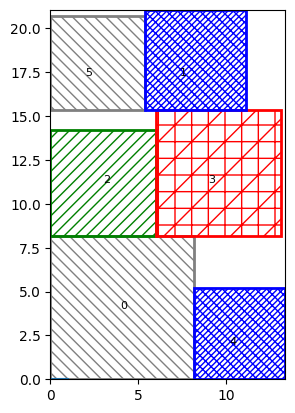

sp_floorplan runtime : 4.0531158447265625e-06


In [51]:
m = [Module(str(i), random.randint(10,100), [1.]) for i in range(6)]
sumarea = sum([i._area for i in m])
for fpfn in [ilp_floorplan, slicing_floorplan, sp_floorplan]:
  t = time.time()
  sol, area = fpfn(m)
  print(f"{fpfn.__name__} runtime :", time.time() - t)
  if sol:
    print(f"{fpfn.__name__} area :", area, "Utilization :", sumarea * 100./area)
    plot(sol)